In [1]:
%pylab inline
rc("image", cmap="gray", interpolation="bicubic")

Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(8,8)

# INPUT PIPELINES

# PyTorch

Classes:

- `torch.utils.data.DataSet` -- random access data sets
- `torch.utils.data.IterableDataset` -- sequential access data sets
- `torch.utils.data.DataLoader` -- multithreaded loading, augmentation, batching

Storage:

- usually as individual files or in LMDB

# TensorFlow

- `TFRecord` / `tf.Example` -- sequential records of serialized data
- used with sharding and object store for large datasets inside Google
- not a lot of tools available outside Google

# PYTORCH DATA LOADING

In [3]:
from torch.utils.data import Dataset, IterableDataset, DataLoader
from torchvision import datasets, transforms

mnist = datasets.MNIST(root="./__CACHE__", download=True)

print(mnist[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x7F56F69BE208>, 5)


- Data in PyTorch is accessed through the `Dataset` or `IterableDataset` classes.
- A `Dataset` behaves just like an array, although in practice, it often loads data from disk.

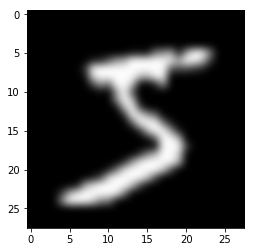

In [4]:
image, label = mnist[0]
figsize(4, 4); imshow(image)

- `Dataset` items are usually pairs of input and target
- Here, we have an input image in `PIL` format and an integer class label

<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32 -0.5 0.5


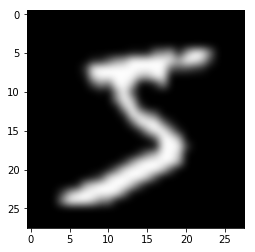

In [99]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

mnist = datasets.MNIST(transform=transform, train=True, root="./__CACHE__", download=True)
image, label = mnist[0]
print(type(image), image.shape, image.dtype, image.min().item(), image.max().item())
imshow(image[0])

- We can specify transformations to be inserted after the initial dataset loading.
- These transformations of perform augmentation and conversion to Torch tensors.

In [6]:
loader = DataLoader(mnist, batch_size=16, shuffle=True)
images, labels = next(iter(loader))
print(type(images), images.shape, images.dtype, images.min().item(), images.max().item())

<class 'torch.Tensor'> torch.Size([16, 1, 28, 28]) torch.float32 -0.5 0.5


- PyTorch models are usually trained on batches.
- The `Dataloader` class takes care of batching.

In [7]:
loader = DataLoader(mnist, batch_size=16, shuffle=True, num_workers=8)
images, labels = next(iter(loader))
print(type(images), images.shape, images.dtype, images.min().item(), images.max().item())

<class 'torch.Tensor'> torch.Size([16, 1, 28, 28]) torch.float32 -0.5 0.5


- Data loading, decompression, and augmentation is often compute intensive and becomes a bottleneck.
- To speed up data loading, the `DataLoader` class can use multiple workers.

# NVIDIA Dali & Tensorcom

- With `DataLoader` all workers still run on the same machine, and the CPU may become a bottleneck.
- NVIDIA Dali offloads a lot of data augmentation to the GPU and can speed up preprocessing substantially.
- Tensorcom offloads data augmentation to other hosts, allowing a large number of CPUs to feed a single GPU.
- Tensorcom also permits the use of RDMA.

# PyTorch Dataset / DataLoader

- widely used, works well on SSD
- `Dataset` is random access = lots of small reads and seeks for Imagenet
- poor performance on network file system and rotational disks
- image decompression and augmentation very CPU intensive

# WebDataset

In [8]:
!unset GZIP; curl -s http://storage.googleapis.com/lpr-imagenet/imagenet_train-0000.tgz | tar -ztvf - | sed 5q

-rw-rw-rw- bigdata/bigdata   3 2019-06-08 12:12 n03788365_17158.cls
-rw-rw-rw- bigdata/bigdata 75884 2019-06-08 12:12 n03788365_17158.jpg
-rw-rw-rw- bigdata/bigdata   382 2019-06-08 12:12 n03788365_17158.json
-rw-rw-rw- bigdata/bigdata     3 2019-06-08 12:12 n03000247_49831.cls
-rw-rw-rw- bigdata/bigdata 57068 2019-06-08 12:12 n03000247_49831.jpg
^C


- `WebDataset` stores data not as individual files, but as standard POSIX tar archives.
- File formats are otherwise unchanged.

In [9]:
from webdataset import WebDataset
imagenet = WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-0000.tgz",
                      extensions="jpg cls")

- Reading a `WebDataset` is as simple as specifying a URL and the extensions you want extract.
- Data can be stored locally (`file:`), on web servers (`http:`, `https:`), and in cloud storage (`gs:`, `s3:`)

852


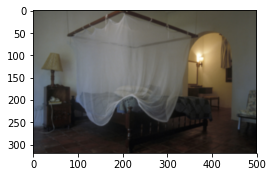

In [11]:
for image, cls in imagenet:
    imshow(image)
    print(cls)
    break

- `WebDataset` allows you to iterate through your samples just like a regular PyTorch dataset
- It has convenient file-based rules for decoding built-in.

In [10]:
print(WebDataset.__base__)
imagenet[0]

<class 'torch.utils.data.dataset.IterableDataset'>


NotImplementedError: 

`WebDataset` is derived from `IterableDataset`, a new dataset type in PyTorch 1.2. It cannot be indexed, only iterated over.

852
torch.Size([3, 319, 500]) 0.0 1.0 torch.float32


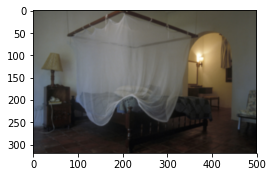

In [13]:
from webdataset import WebDataset
imagenet = WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-{0000..0147}.tgz",
                      extensions="jpg cls", decoder="torch")

for image, cls in imagenet:
    break
imshow(image.permute(1, 2, 0))
print(cls)
print(image.shape, image.min().item(), image.max().item(), image.dtype)

- You can decode automatically to NumPy (default), Torch, and PIL.
- You can decode images to 8 bit or float, grayscale or color
- If you want to handle decoding completely yourself, just set `decoder=None`

In [101]:
from torchvision import transforms

augment = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

- The `torchvision` package contains a number of common data transformations and augmentations.
- This pipeline is commonly used with Imagenet training.
- These generally operate on PIL image types.

851


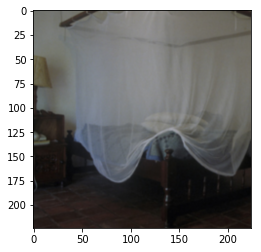

In [15]:
from webdataset import WebDataset
imagenet = WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-{0000..0147}.tgz",
                      extensions="jpg cls",
                      decoder="pil",
                      transforms=[augment, lambda x: x-1])

for image, cls in imagenet:
    break
imshow(image.permute(1, 2, 0))
print(cls)

- Insert the transforms using the `transforms=` argument.
- Note that unlike `Dataset`, `WebDataset` takes a list of transforms corresponding to each element of the output tuple.

921


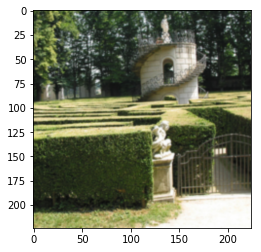

In [16]:
from webdataset import WebDataset
imagenet = WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-{0000..0147}.tgz",
                      shuffle=100,
                      extensions="jpg cls",
                      decoder="pil",
                      transforms=[augment, lambda x: x-1])

for image, cls in imagenet:
    break
imshow(image.permute(1, 2, 0))
print(cls)

- Web datasets are usually split up into multiple shards.
- Shards are referred to using standard Bash brace expansion syntax.
- This brace expansion is carried out internally.
- Sharding is important both for achiving faster I/O speeds and for shuffling data.

In [21]:
imagenet = WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-{0000..0147}.tgz",
                      extensions="jpg cls",
                      decoder="pil",
                      transforms=[augment, lambda x: x-1])
loader = DataLoader(imagenet, batch_size=16, num_workers=8)
images, classes = next(iter(loader))
print(images.size(), classes.size())

torch.Size([16, 3, 224, 224]) torch.Size([16])


- `WebDataset` combines with `DataLoader` and parallel augmentation just like any other `Dataset`
- When using multiple workers, each worker is assigned a distinct shard.

# WebDataset

- just store datasets as tar files on web server, object store, etc.
- drop-in replacement for PyTorch's `Dataset`
- same preprocessing methods

Advantages:
- sequentials reads -- much faster on rotational drives
- achieves SSD-like performance for petabyte datasets on network shares
- easier to manage than millions of files

# TARPROC

The `tarproc` package contains a number of tools that operate on datasets stored as tar files:

- tar2tsv -- extract data from tar files and put into CSV format
- tarcat -- concatenate tar files
- tarcreate -- create a tar file from a CSV/TSV plan
- tarfirst -- extract the first file matching some criteria
- tarpcat -- parallel tar concatenation/shuffle
- tarproc -- xargs running over tar files
- tarshow -- display contents of tar files as text or images
- tarsort -- sort the contents of a tar file by key
- tarsplit -- split a tar file into shards

In [62]:
!gsutil cat gs://lpr-imagenet/imagenet_train-0000.tgz | tarscat -c 10 > small.tar

!tar tvf small.tar | fgrep .jpg | wc -l

10


Tar files can be pipelined, just like other kinds of UNIX jobs.

`tarscat -c 10` reads 10 samples from the input, writes them to the output, and quits.

In [90]:
!tar2tsv -f cls small.tar

__key__	cls
n03788365_17158	852
n03000247_49831	902
n03000247_22907	902
n04597913_10741	951
n02117135_412	34
n03977966_79041	285
n04162706_8032	589
n03670208_11267	270
n02782093_1594	233
n02172182_3093	626


`tar2tsv` extracts data from tar files and tabulates it.

In [31]:
!tar -cf - --sort=name -C /mdata/imagenet-raw train | tarsplit -s 1e9 -o imagenet_train --maxshards 2

# writing imagenet_train-000000.tar (0, 0)
# writing imagenet_train-000001.tar (9173, 1000004876)
tar: -: Wrote only 4096 of 10240 bytes
tar: Error is not recoverable: exiting now


To create sharded tar files, tar up your original dataset (either with `tar --sorted` or `tarpcat`) and pipe it to `tarsplit`.

In [64]:
!tarshow  -c 2 small.tar

__key__             	n03788365_17158
__source__          	b'-'
cls                 	b'852'
jpg                 	b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x0e\xd8\x0e\x
json                	b'{"annotation": {"folder": "n03788365", "filename": "n03788

__key__             	n03000247_49831
__source__          	b'-'
cls                 	b'902'
jpg                 	b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\xf0\x00\x
json                	b'{"cls": 902, "cname": "chain mail, ring mail, mail, chain 



`tarshow` will show the contents of a tar file, and optionally display images.

In [65]:
!tarproc -p 5 -c 'ls; gm mogrify -size 256x256 *.jpg -resize 256x256' small.tar > out.tar

`tarproc` allows you to map shell scripts of samples comprising a dataset. Here, we resize all the `.jpg` files in our dataset to a given size using the GraphicsMagick `mogrify` tool.

This code also runs in parallel on 5 cores.

In [86]:
#kujob -s '{0000..0999}' -- tarproc -p 16 -c 'run-ocr *.png' gs://g1000/scanned-{}.tar -o gs://g1000/ocr-{}.tar

Combined with a job queueing system (here Kubernetes `kujob`), we can easily process very large sharded datasets.

This runs an OCR engine over 1000 shards representing the 1000 scanned books in the Google 1000 Books dataset; each shard is run in parallel as a separate job, and within each job, 16 pages are processed in parallel.

# PYTHON BASED MAP-REDUCE

In [93]:
from webdataset.writer import TarWriter
sink = TarWriter("out2.tar")

def process_sample(sample):
    return dict(__key__=sample["__key__"],
                  png=sample["jpg"].resize((256, 256)),
                  cls=str(sample["cls"]))

for sample in WebDataset("small.tar", decoder="pil"):
    sink.write(process_sample(sample))

sink.close()

Processing many files is also easy from Python. Here, we resize the `.jpg` file in each sample using PIL, then write teh output to another tar file. This is all fast, sequential dataset reading.

In [94]:
import multiprocessing as mp
pool = mp.Pool(8)

processed = pool.imap_unordered(process_sample, WebDataset("small.tar", decoder="pil"))

with TarWriter("out2.tar") as sink:
    for sample in processed: sink.write(sample)

Combined with Python `multiprocessing`, you can perform large scale parallel processing of shards.

In [95]:
def distributed_map_unordered(*args, **kw): pass

In [98]:
import multiprocessing as mp
pool = mp.Pool(8)

def process_shard(input_shard, output_shard):
    processed = pool.imap_unordered(process_sample, WebDataset(input_shard, decoder="pil"))
    with TarWriter(output_shard) as sink:
        for sample in processed: sink.write(sample)

shards = [(f"gs://mybucket/original-{i:04d}.tar", f"gs://mybucket/rescaled-{i:04d}.tar")
              for i in range(1000)]
            
distributed_map_unordered(process_shard, shards)

You can also use your favorite distributed queueing and processing framework for Python to execute very large scale data processing jobs just from Python.

# Large Scale, Multi-Server Training

<img src="figs/distributed.jpg" width=800>


# Large Scale Distributed Training

- commonly 16-256 GPUs training from the same dataset
- 200-1000 GB/s input data rate per GPU
- disk : GPU ratio of 2:1 to 10:1
- CPU node : GPU node ratio of 2:1
- on average, each disk only used by at most one GPU
- data is cached from archival storage to dedicated disks
- all protocols are HTTP (WebDav for management operations)